In [10]:
import sys
sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/semi_supervised/')
import coreg
reload(coreg)
import trireg
reload(trireg)
sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/ordinal/')
import simple
reload(simple)
sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/ensemble/')
import stacking
reload(stacking)


import pandas as pd
import numpy as np
from sklearn import preprocessing
import xgboost as xgb

import transformers as tforms
reload(tforms)
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union

import metrics
reload(metrics)
from sklearn.cross_validation import StratifiedKFold, train_test_split

from sklearn.base import clone

from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Ridge, Lasso, SGDRegressor
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, ExtraTreesRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.isotonic import IsotonicRegression

from sklearn.preprocessing import StandardScaler

from collections import Counter
import minirank as mr

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from time import time

import cPickle as pickle

def wgmean(x, w):
    return np.exp(np.sum(w*np.log(x), axis=1) / np.sum(w, axis=1))

In [175]:
# Load Data
train_pd  = pd.read_pickle('saved/train_pd_enc.p')
test_pd  = pd.read_pickle('saved/test_pd_enc.p')
labels = pd.read_pickle('saved/labels.p')
test_ind = pickle.load(open('saved/test_ind.p'))
y_binned = np.load('saved/y_binned.npy')
fi = np.load('saved/feature_importances.npy')

y_binned[y_binned==6] = 5

# drop_cols = ['T1_V10', 'T1_V13', 'T2_V7', 'T2_V10']
# drop_cols = []

drop_cols = train_pd.columns[fi < 0.01]


for col in drop_cols:
    train_pd.drop(col, axis=1, inplace=True)
    test_pd.drop(col, axis=1, inplace=True)

In [140]:
# Load Data le instead
# train_pd  = pd.read_pickle('saved/train_pd_l_enc.p')
# test_pd  = pd.read_pickle('saved/test_pd_l_enc.p')

train_pd  = pd.read_pickle('saved/train_pd_le_and_oh_enc.p')
test_pd  = pd.read_pickle('saved/test_pd_le_and_oh_enc.p')

labels = pd.read_pickle('saved/labels.p')
test_ind = pickle.load(open('saved/test_ind.p'))
y_binned = np.load('saved/y_binned.npy')
fi = np.load('saved/feature_importances.npy')

y_binned[y_binned==6] = 5

drop_cols = ['T1_V10', 'T1_V13', 'T2_V7', 'T2_V10']
# drop_cols = []

# drop_cols = train_pd.columns[fi < 0.01]


for col in drop_cols:
    train_pd.drop(col, axis=1, inplace=True)
    test_pd.drop(col, axis=1, inplace=True)

In [3]:
# Load Data binary instead
train_pd  = pd.read_pickle('saved/train_pd_binary_enc.p')
test_pd  = pd.read_pickle('saved/test_pd_binary_enc.p')
labels = pd.read_pickle('saved/labels.p')
test_ind = pickle.load(open('saved/test_ind.p'))
y_binned = np.load('saved/y_binned.npy')


In [141]:
X_tsne2_26 = np.load('saved/X_tsne2_26important.npy')
X_tsne2_26_train = X_tsne2_26[:len(train_pd), :]
X_tsne2_26_test = X_tsne2_26[-len(test_pd):, :]

X_tsne2 = np.load('saved/X_tsne2.npy')
X_tsne2_train = X_tsne2[:len(train_pd), :]
X_tsne2_test = X_tsne2[-len(test_pd):, :]

print X_tsne2_train.shape
print X_tsne2_test.shape
print X_tsne2_26_train.shape
print X_tsne2_26_test.shape

(50999, 2)
(51000, 2)
(50999, 2)
(51000, 2)


In [142]:
train = np.array(train_pd)
test = np.array(test_pd)

X_train = train.astype(float)
X_test = test.astype(float)
y_train = np.array(labels)

try:
    X_train = np.c_[X_train, X_tsne2_26_train]
    X_test = np.c_[X_test, X_tsne2_26_test]
except:
    pass

holdout = False
if holdout:
    X_train, X_hold, \
    y_train, y_hold, \
    y_binned, y_binned_hold \
    = train_test_split(
        X_train, y_train, y_binned, 
        test_size=0.2, random_state=0)


pipe_x = make_pipeline(
    make_union(
        tforms.IdentityTformer(),
#         make_pipeline(AddTformer(1), BoxCoxTformer()),
#         AnscombeTformer(),
    ),
#     StandardScaler(),
)
pipe_y = make_pipeline(
    tforms.IdentityTformer(),
#     tforms.BoxCoxTformer(),
#     tforms.LogTformer(),
#     tforms.AnscombeTformer(),
#     tforms.FreemanTukeyTformer(),
#     tforms.ArcsinhTformer(),
#     StandardScaler(),
    
)
pipe_x.fit(np.r_[X_train, X_test])
pipe_y.fit(y_train)

X_train = pipe_x.transform(X_train)
X_test = pipe_x.transform(X_test)
try:
    X_hold = pipe_x.transform(X_hold)
except:
    pass
# y_train = pipe_y.fit_transform(y_train)

# small_n = 5000
# X_train = X_train[:small_n,:]
# y_train = y_train[:small_n]
# y_binned = y_binned[:small_n]

print 'y_train', y_train.shape
print 'X_train', X_train.shape
print 'X_test', X_test.shape
try:
    print 'X_hold', X_hold.shape
except:
    pass
print len(np.unique(y_train))
print len(np.unique(y_binned))
print type(X_train[0][0])

y_train (50999,)
X_train (50999, 125)
X_test (51000, 125)
X_hold 50
5
<type 'numpy.float64'>


In [98]:
pipe_y.transform(y_train)

array([ 0.88137359,  2.09471255,  0.88137359, ...,  1.81844646,
        3.33347759,  2.89344399])

In [164]:
et = ExtraTreesRegressor(n_estimators=400, max_depth=9, n_jobs=-1)
et.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=9,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=400, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

111

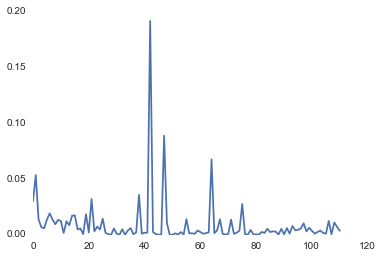

In [174]:
fi = et.feature_importances_

plt.plot(fi)

train_pd.columns[fi >0.01]
len(train_pd.columns)

In [115]:
# y_binned[y_binned==6] = 5
Counter(y_binned_train)

Counter({1: 15196, 3: 10578, 2: 6605, 4: 6326, 5: 2092, 6: 2})

In [143]:
# gbm = xgb.XGBRegressor(
#     objective="reg:linear",
#     n_estimators=600,
#     learning_rate=0.005,
# #     gamma=0.0,
#     max_depth=9,
#     min_child_weight=6,
# #     max_delta_step=10,
#     subsample=0.7,
#     colsample_bytree=0.7,
# #     scale_pos_weight=1.0,
#     base_score=0.5,
#     nthread=7,
#     seed=np.random.randint(0,100),
#     silent=True,
# )

params = {}
params["objective"] = "reg:linear"
params["eta"] = 0.005
params["min_child_weight"] = 6
params["subsample"] = 0.7
params["colsample_bytree"] = 0.7
# params["max_delta_step"] = 10
params["silent"] = 1
params["max_depth"] = 9 #7
params["scale_pos_weight"] = 1.0
# params["gamma"] = 0

plst = list(params.items())
max_rounds = 1500

k = 3
skf = StratifiedKFold(y_binned, n_folds=k)



In [144]:
tic = time()

scores = []
models = []

for ii, (train_ind, val_ind) in enumerate(skf):
    print 'Fold %d' % ii,
    X_train_k, y_train_k = X_train[train_ind], y_train[train_ind]
    X_valid_k, y_valid_k = X_train[val_ind], y_train[val_ind]
    
    train_dm = xgb.DMatrix(X_train_k, pipe_y.transform(y_train_k))
    val_dm = xgb.DMatrix(X_valid_k, pipe_y.transform(y_valid_k))
    
    # Train
    watchlist = [(train_dm, 'train'),(val_dm, 'val')]
    model = xgb.train(plst, train_dm, max_rounds, watchlist, early_stopping_rounds=120)
    models.append(model)

    # Validate gini
    val_preds = model.predict(val_dm, ntree_limit=model.best_iteration)
    score = metrics.normalized_gini(y_valid_k, val_preds)
    print score
    scores.append(score)
    
#     break

toc = time() - tic
print 'Time:', toc


Will train until val error hasn't decreased in 120 rounds.
[0]	train-rmse:5.308405	val-rmse:5.381009
[1]	train-rmse:5.295116	val-rmse:5.368504
[2]	train-rmse:5.281818	val-rmse:5.356035
[3]	train-rmse:5.268765	val-rmse:5.343699
[4]	train-rmse:5.255376	val-rmse:5.331357
[5]	train-rmse:5.242510	val-rmse:5.319285
[6]	train-rmse:5.229374	val-rmse:5.307202
[7]	train-rmse:5.216628	val-rmse:5.295433
[8]	train-rmse:5.203839	val-rmse:5.283589
[9]	train-rmse:5.191164	val-rmse:5.271842
[10]	train-rmse:5.178603	val-rmse:5.260085
[11]	train-rmse:5.166125	val-rmse:5.248405
[12]	train-rmse:5.153645	val-rmse:5.236887
[13]	train-rmse:5.141370	val-rmse:5.225397
[14]	train-rmse:5.129222	val-rmse:5.213956
[15]	train-rmse:5.117146	val-rmse:5.202616
[16]	train-rmse:5.105191	val-rmse:5.191393
[17]	train-rmse:5.093014	val-rmse:5.180191
[18]	train-rmse:5.081152	val-rmse:5.169178
[19]	train-rmse:5.069382	val-rmse:5.158197
[20]	train-rmse:5.057513	val-rmse:5.147320
[21]	train-rmse:5.045854	val-rmse:5.136614
[22]	

Fold 0 

[1370]	train-rmse:3.039328	val-rmse:3.822265
[1371]	train-rmse:3.039114	val-rmse:3.822297
Stopping. Best iteration:
[1251]	train-rmse:3.074203	val-rmse:3.821752

Will train until val error hasn't decreased in 120 rounds.
[0]	train-rmse:5.331629	val-rmse:5.335317
[1]	train-rmse:5.318223	val-rmse:5.322584
[2]	train-rmse:5.304982	val-rmse:5.309993
[3]	train-rmse:5.291573	val-rmse:5.297479
[4]	train-rmse:5.278667	val-rmse:5.285102
[5]	train-rmse:5.265795	val-rmse:5.272870
[6]	train-rmse:5.252852	val-rmse:5.260547
[7]	train-rmse:5.239755	val-rmse:5.248227
[8]	train-rmse:5.226992	val-rmse:5.236220
[9]	train-rmse:5.214303	val-rmse:5.224360
[10]	train-rmse:5.201658	val-rmse:5.212276
[11]	train-rmse:5.189092	val-rmse:5.200453
[12]	train-rmse:5.176628	val-rmse:5.188653
[13]	train-rmse:5.164430	val-rmse:5.177010
[14]	train-rmse:5.152365	val-rmse:5.165561
[15]	train-rmse:5.139982	val-rmse:5.154077
[16]	train-rmse:5.127971	val-rmse:5.142933
[17]	train-rmse:5.115974	val-rmse:5.131787
[18]	train-rmse

0.392958746537
Fold 1 

[1217]	train-rmse:3.085355	val-rmse:3.767911
[1218]	train-rmse:3.085039	val-rmse:3.767880
Stopping. Best iteration:
[1098]	train-rmse:3.122750	val-rmse:3.767391

Will train until val error hasn't decreased in 120 rounds.
[0]	train-rmse:5.357237	val-rmse:5.283040
[1]	train-rmse:5.343618	val-rmse:5.270254
[2]	train-rmse:5.330325	val-rmse:5.257702
[3]	train-rmse:5.317249	val-rmse:5.245242
[4]	train-rmse:5.303962	val-rmse:5.232975
[5]	train-rmse:5.290823	val-rmse:5.220660
[6]	train-rmse:5.277691	val-rmse:5.208326
[7]	train-rmse:5.264492	val-rmse:5.196275
[8]	train-rmse:5.251873	val-rmse:5.184467
[9]	train-rmse:5.239170	val-rmse:5.172641
[10]	train-rmse:5.226516	val-rmse:5.160627
[11]	train-rmse:5.214172	val-rmse:5.148903
[12]	train-rmse:5.201797	val-rmse:5.137362
[13]	train-rmse:5.189530	val-rmse:5.125791
[14]	train-rmse:5.177137	val-rmse:5.114284
[15]	train-rmse:5.165019	val-rmse:5.102942
[16]	train-rmse:5.152779	val-rmse:5.091655
[17]	train-rmse:5.140957	val-rmse:5.080501
[18]	train-rmse

0.378020357115
Fold 2 0.377425200227
Time: 123.548567057


[1052]	train-rmse:3.141579	val-rmse:3.738872
Stopping. Best iteration:
[932]	train-rmse:3.183641	val-rmse:3.738346



In [148]:
print scores
print np.mean(scores)

[0.3929587465373823, 0.37802035711532644, 0.3774252002266639]
0.382801434626



[0.39490425906466936, 0.37890179668016233, 0.377554911994436]
0.383786989246

[0.3910503647948182, 0.3780944592060871, 0.3770922765104607]
0.382079033504


[0.3890283087770394, 0.3724811614653284, 0.3710721844131394]
0.377527218219


[0.3944362886094996, 0.37739978156836, 0.37692043516998874]
0.382918835116


[0.3705624539664949, 0.41210865765502785, 0.4198988833486742, 0.3599310620636312, 0.40290371865977637, 0.37518703515316154, 0.3887060281188471, 0.391235399620686, 0.3737678345130346, 0.37424844683418074]
0.386854951993

after the drop


[0.3773651806063395, 0.4150909783919717, 0.42037060564860446, 0.36415380489629273, 0.40105340067107775, 0.3751298251442507, 0.38272684411126795, 0.3900262781590605, 0.37638357756785856, 0.3779500838160977]
0.388025057901


[0.3702890164144098, 0.40356396248068643, 0.39484067019778785, 0.36537202585393, 0.388509413481554, 0.37741993479369657, 0.3908215359771405, 0.3938671390265319, 0.38779293002007736, 0.3495651658415825]
0.382204179409

coefficients of linaer regression on the hldout set
    array([ 0.18323449,  0.17657944,  0.39015021, -0.37579011, -0.02563551,
           -0.01710503,  0.64589146, -0.2369072 , -0.0815921 ,  0.42571541])
           
           
Label encoded and tsne2
[0.3662049744496147, 0.40725765062476815, 0.41536529161842745, 0.35522601415427923, 0.404535662653632, 0.37093325930916393, 0.392662863295279, 0.3922876591767482, 0.37788267988202695, 0.3754994054266433]
0.385785546059

Log
[0.38924656929754003, 0.37751236888002554, 0.37786934601480004]
0.381542761397

In [144]:
# Meta est
print len(models)
hold_dm = xgb.DMatrix(X_hold)
base_preds = []
for model in models:
    base_pred = model.predict(hold_dm, ntree_limit=model.best_iteration)
    base_preds.append(base_pred)

10


In [146]:
base_preds_arr = np.array(base_preds).T
meta = LinearRegression().fit(base_preds_arr, y_hold)
meta.coef_

array([ 0.18323449,  0.17657944,  0.39015021, -0.37579011, -0.02563551,
       -0.01710503,  0.64589146, -0.2369072 , -0.0815921 ,  0.42571541])

(array([  1.89810000e+04,   0.00000000e+00,   8.17000000e+03,
          0.00000000e+00,   1.33250000e+04,   0.00000000e+00,
          7.91700000e+03,   0.00000000e+00,   2.60300000e+03,
          3.00000000e+00]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ]),
 <a list of 10 Patch objects>)

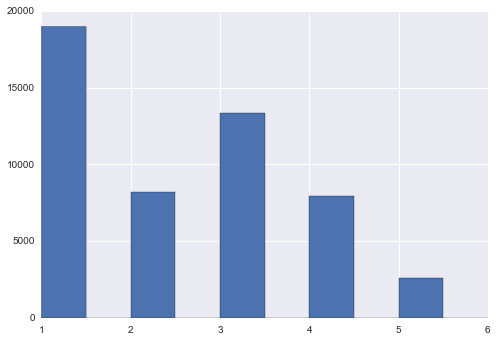

In [10]:
plt.hist(y_binned)

In [45]:
test_dm = xgb.DMatrix(X_test)
test_preds_l = []
for model in models:
    test_preds = model.predict(test_dm, ntree_limit=model.best_iteration)
    test_preds_l.append(test_preds)

In [46]:
test_pred_arr = np.array(test_preds_l)
test_pred_arr.shape

w = np.ones(len(test_pred_arr))
# w = np.array([ 0.18323449,  0.17657944,  0.39015021, -0.37579011, -0.02563551,
#               -0.01710503,  0.64589146, -0.2369072 , -0.0815921 ,  0.42571541])
# w = np.clip(w, 0, 1)
# print w

# test_final_preds = test_pred_arr.mean(axis=0)
test_final_preds = np.dot(w, test_pred_arr)
print test_final_preds.shape

(51000,)


In [47]:
# Submission

preds_test = pd.DataFrame({"Id": test_ind, "Hazard": test_final_preds})
preds_test = preds_test.set_index('Id')
preds_test.to_csv('submissions/xgboost_3bag_squared_y.csv')